[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PyMPDATA.git/master?filepath=PyMPDATA_examples/Olesik_et_al_2020/demo_analytical_solution.ipynb)    
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PyMPDATA/blob/master/PyMPDATA_examples/Olesik_et_al_2020/demo_analytical_solution.ipynb)    

In [1]:
import os, sys
if 'google.colab' in sys.modules:
    %cd /content
    if not os.path.isdir('PyMPDATA'):
        !git clone --depth 1 https://github.com/atmos-cloud-sim-uj/PyMPDATA.git
        %cd PyMPDATA
    else:
        %cd PyMPDATA
        !git pull
    !pip install -r requirements.txt
    !ldconfig

In [2]:
import os, sys
if 'google.colab' in sys.modules:
    %cd /content/PyMPDATA
else:
    sys.path.insert(0, os.path.join(os.getcwd(), '../..'))

In [3]:
import numpy as np
from matplotlib import pyplot
from scipy import optimize, integrate
import pint, math

In [4]:
si = pint.UnitRegistry()
si.setup_matplotlib()
t_unit = si.s
r_unit = si.um
p_unit = r_unit **2
n_unit = si.cm ** -3 / r_unit

def mgn(quantity, unit):
    return quantity.to(unit).magnitude

In [8]:
rho_w = 1 * si.kg / si.dm ** 3
rho_a = 1 * si.kg / si.m ** 3

r_min = 1 * si.um
r_max = 25 * si.um
nr = 100
mixing_ratios = np.array([1, 4,10])

ksi_0 = 100 * si.um ** 2 / si.s
S = 1.00075
ksi = (S - 1)* ksi_0
drdt = lambda r: ksi / r  

unnormalised_pdf = lambda r:  (
                (700 / si.cm**3 * si.um) / r *
                np.exp(- 22 * (np.log10(r / (7 * si.um)) ** 2)) *
                (1 / si.um))

def mixing_ratio(arg):
    r_min = .1 * si.um
    while not np.isfinite(arg(r_min).magnitude):
        r_min *= 1.01
    def pdfarg(r_nounit):
        r = r_nounit * r_unit
        result = arg(r) * r ** 3
        return result.to(n_unit * r_unit ** 3).magnitude
    I = integrate.quad(pdfarg,
                       r_min.to(r_unit).magnitude,
                       np.inf
                       )[0] * n_unit * r_unit ** 4
    return (I * 4 / 3 * np.pi * rho_w / rho_a).to(si.g / si.kg)

norm = (1 * si.g / si.kg) / mixing_ratio(unnormalised_pdf)

def pdf(r):
    return unnormalised_pdf(r) * norm

def pdfevolver(pdf, drdt,t):
    pdf_t = lambda r: r /  np.sqrt(r ** 2 - 2 * ksi * t) * pdf(np.sqrt(r ** 2 - 2 * ksi * t))
    return pdf_t

out_times = []

for mr in mixing_ratios * si.g / si.kg:
    def findroot(ti):
        return (mr - mixing_ratio(pdfevolver(pdf, drdt, ti * t_unit))).magnitude
    t_unit = si.second
    t = optimize.brentq(findroot, 0, (1 * si.hour).to(t_unit).magnitude)
    out_times.append(t)

/usr/local/lib/python3.8/dist-packages/pint/numpy_func.py:295: RuntimeWarning: invalid value encountered in sqrt
  result_magnitude = func(*stripped_args, **stripped_kwargs)


In [9]:
def calculate_dt(r_min, r_max, pdf_of_r, drdt_of_r):            
        dp_dr = lambda r: 2*r
        xh, dx = np.linspace(
            np.log(r_min**3) / np.log(np.e),
            np.log(r_max**3) / np.log(np.e),
            nr + 1,
            retstep=True
        )
        rh = np.e**(xh/3)
        dp_dt = drdt_of_r(rh) * dp_dr(rh)
        dt = 0.9 * dx / np.amax(dp_dt)        
        return dt

dt = calculate_dt(
            mgn(r_min, r_unit),
            mgn(r_max, r_unit),
            lambda r: mgn(pdf(r * r_unit), n_unit),
            lambda r: mgn(drdt(r * r_unit), r_unit / t_unit)
        ) 
out_steps = tuple([math.ceil(t/dt) for t in out_times])
dt*= t_unit

T = 0.0 second
T = 745.1053759404627 second
T = 1749.7808983982873 second


/usr/local/lib/python3.8/dist-packages/pint/numpy_func.py:295: RuntimeWarning: invalid value encountered in sqrt
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/usr/local/lib/python3.8/dist-packages/pint/numpy_func.py:295: RuntimeWarning: invalid value encountered in sqrt
  result_magnitude = func(*stripped_args, **stripped_kwargs)


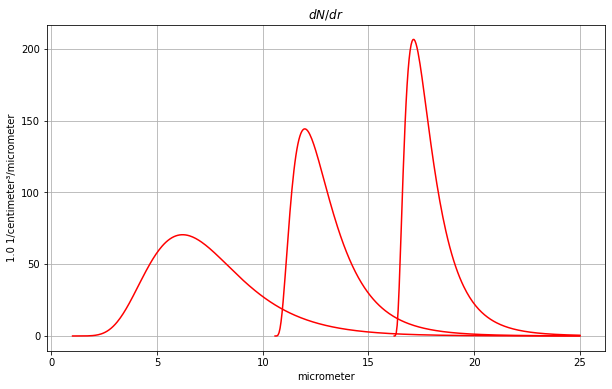

In [10]:
x = np.linspace(
            r_min.magnitude,
            r_max.magnitude,
            512
        ) *r_unit

fig, axs = pyplot.subplots(1, 1, figsize=(10,6))
axs.yaxis.set_units(1 / si.um / si.cm ** 3)
axs.xaxis.set_units(si.um)
axs.grid()
axs.set_title('$dN/dr$')
for i in range(len(out_steps)):
    t = out_steps[i] * dt
    print('T =', t)
    pdf_t = pdfevolver(pdf, drdt, t)
    y = pdf_t(x)
    axs.plot(x, y, color='red')
pyplot.show()